[sample data length is 60000 | number of classes is 10]
((0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949))


100%|██████████| 50/50 [02:00<00:00,  2.42s/it]


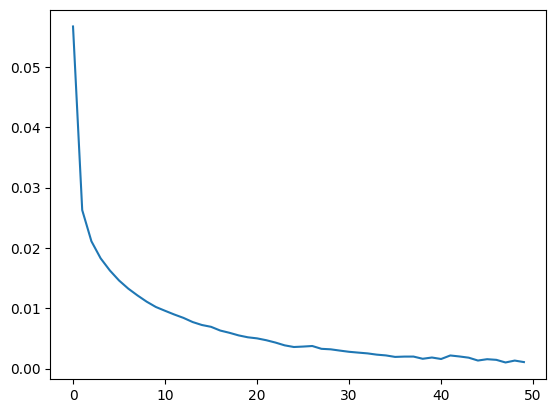

In [18]:
from tqdm import tqdm
from numpy import array
from layers.loss_functions import CrossEntropy
from layers.activation_layer import ActivationLayer
import numpy as np
from dataloader.dataloader import DataLoader
from datasets.mnist_dataset import Dataset
from ops.transformations import transform_registry
from utils.config import Config
from layers.fc_layer import FCLayer
from matplotlib import pyplot as plt

# num batches to draw
N = 3


def parse_transform(p_transforms):
    transforms = []
    for transform in p_transforms:
        for name, kwargs in transform.items():
            transforms.append(transform_registry.get(name, vars(kwargs)))
    return transforms


# train
train_cfg = Config.from_file('../configs/task1/task1_train.json')
train_params = vars(train_cfg.data)
train_params['transforms'] = []  #parse_transform(train_params['transforms'])

ds = Dataset(**train_params)

dl = DataLoader(ds, 10, 'train', False, 64, 'default')
ds.read_data()

layers = [
    FCLayer(28 * 28, 128),
    ActivationLayer(128, 128),
    FCLayer(128, 10),
    ActivationLayer(10, 10, 'sigmoid'),
]

loss = CrossEntropy()


def forward_pass(x):
    ip = x
    for layer in layers:
        ip = layer(ip, 'train')

    return ip


lambd = 0.01


def backprop(loss_grad):
    for layer in reversed(layers):
        loss_grad = layer.backward(loss_grad)
        if layer.trainable:
            layer.update_weights(lambda v, grad: v - lambd * grad)


# for _ in range(N):
#     image, l = next(dl.batch_generator())

epoch_acc = []
epoch_loss = []
for epoch in tqdm(range(50)):
    batch_error = []
    batch_loss = []
    for image, l in dl.batch_generator():
        l = array([dl.dataset.one_hot_labels(ll) for ll in l])

        shape = np.product(image[0].shape)
        flatten = image.reshape((-1, shape)) / 255

        res = forward_pass(flatten)
        loss_grad = loss.gradient(l, res)
        backprop(loss_grad)

        batch_error.append(loss.acc(l, res))
        batch_loss.append(np.mean(loss.loss(l, res)))

    epoch_acc.append(np.mean(batch_error))
    epoch_loss.append(np.mean(batch_loss))

# plt.plot(range(50), epoch_acc)
plt.plot(range(50), epoch_loss)
plt.show()

guessed: 0, actually: 5
guessed: 0, actually: 2
guessed: 1, actually: 2


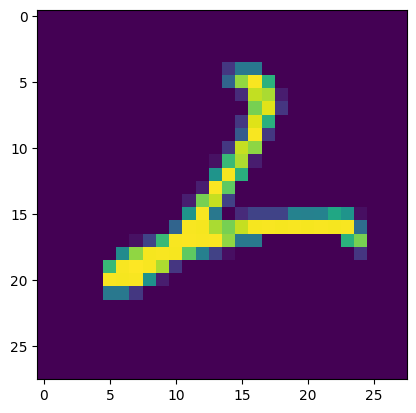

In [51]:
# train
train_cfg = Config.from_file('../configs/task1/task1_test.json')
train_params = vars(train_cfg.data)
train_params['transforms'] = []  #parse_transform(train_params['transforms'])

ds = Dataset(**train_params)

dl = DataLoader(ds, 10, 'train', False, 64, 'default')
ds.read_data(True)
# for img, label in dl.batch_generator():
img, label = next(dl.batch_generator())
for i in range(64):
    fimg = img[i].reshape((1, np.product(img[i].shape)))
    res = forward_pass(fimg)
    if np.argmax(res) != label[i]:
        print(f'guessed: {np.argmax(res)}, actually: {label[i]}')
        plt.imshow(img[i])
        plt.plot()

